In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import fnmatch
import sys
import h5py
import pickle
import pandas as pd
from typing import Dict, List, Any
from tqdm import tqdm

from scipy import stats, optimize, interpolate
from scipy.stats import alexandergovern, f_oneway

import warnings # highly illegal move to make pandas compliant
warnings.simplefilter(action='ignore', category=FutureWarning)

# Exploring the data from Cortical Lab
### Everything is stocked in .h5 hierarchical files, that contain both spiketimes and electrode/channel information

## Exploring the .h5 file structure 

In [2]:
def print_structure(name, obj):
    """Prints the structure of the H5 file.

    Args:
    name : str
        Name of the object.
    obj : H5 object
        The object itself.
    """
    print(name)
    if isinstance(obj, h5py.Dataset):
        print('Dataset', obj.shape, obj.dtype)
    elif isinstance(obj, h5py.Group):
        print('Group')
    print('-')
def explore_h5_file(filename):
    """Explore the structure of an H5 file.

    Args:
    filename : str
        Path to the H5 file.
    """
    with h5py.File(filename, 'r') as file:
        file.visititems(print_structure)

# Use the function
explore_h5_file('../data/cortical_labs_data/11614.2021-06-02.0.h5')

assay
Group
-
assay/inputs
Group
-
mapping
Dataset (900,) [('channel', '<i4'), ('electrode', '<i4'), ('x', '<f8'), ('y', '<f8')]
-
message_0
Dataset (1,) |S12
-
proc0
Group
-
proc0/spikeTimes
Dataset (221562,) [('frame_no', '<u8'), ('channel', '<u4'), ('amplitude', '<f4')]
-
settings
Group
-
settings/gain
Dataset (1,) float64
-
settings/hpf
Dataset (1,) float64
-
settings/lsb
Dataset (1,) float64
-
sig
Dataset (1028, 0) uint16
-
time
Dataset (1,) |S12
-
version
Dataset (1,) |S12
-


## Let's define some helper function to handle their H5 data (adapted from the code provided by Forough and Moein)

In [3]:
def read_maxwell_h5(data_path: str) -> pd.DataFrame:
    """
    Extracts frame, channel, amplitude, electrode id, x, y, chip_id, date, and session from MAxwell H5 files.

    Args:
        data_path: directory of the spikeword (.npy) files

    Returns:
        data: dataframe including all of the information above about each H5 file
    """
    data = pd.DataFrame()

    for filename in tqdm(os.listdir(data_path), desc = 'Loading data...', total = len(os.listdir(data_path))):
        if filename.endswith('.h5'):

            full_filename = os.path.join(data_path, filename)

            with h5py.File(full_filename, 'r') as f:
                proc0 = f['proc0']
                spike_times = np.array(proc0['spikeTimes'])

                if len(spike_times) > 0:
                    file_data = h5_to_pd(full_filename)

                    file_data['count'] = 1
                    file_data['chip_id'] = filename.split('.')[0]
                    file_data['date'] = filename.split('.')[1]
                    
                    # Extract session if it exists in filename
                    split_filename = filename.split('.')
                    if len(split_filename) >= 3:
                        try:
                            file_data['session'] = int(split_filename[2])
                        except ValueError:
                            print(f"No valid session number found in {filename}. 'session' will be NaN for this file.")
                            file_data['session'] = np.nan
                    else:
                        file_data['session'] = np.nan

                    if data.empty:
                        data = file_data
                    else:
                        data = pd.concat([data, file_data], ignore_index=True)

    return data



def h5_to_pd(filename: str) -> pd.DataFrame:
    """Converts a H5 file to a pandas dataframe.

    Args:
        filename: The name of the file to convert

    Returns:
        pd.DataFrame: The converted dataframe
    """
    with h5py.File(filename, 'r') as file:
        maps = pd.DataFrame(np.array(file['mapping']).tolist(), columns=['channel', 'electrode', 'x', 'y'])

        ar = np.array(file['proc0']['spikeTimes'])
        spikes = pd.DataFrame(ar.tolist(), columns=['frame', 'channel', 'amplitude'])

        df = spikes.merge(maps, on='channel', how='left')
        df['frame'] -= df['frame'].iloc[0]  # Normalizing frame values

    return df

## Now some functions to get the spike times

In [4]:
def group_by_channels(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """Group dataframe by 'channel' and return a dictionary."""
    channels = {}
    for i, g in df.groupby('channel'):
        channels.update({f'channel_{i}': g.reset_index(drop=True)})
    return channels


def process_channels(channels: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
    """Process channels dictionary and replace dataframes with 'frame' series."""
    processed_channels = {}
    for channel_id, df in channels.items():
        processed_channels[channel_id] = df['frame']
    return processed_channels


def extract_attributes(channels: Dict[str, pd.DataFrame]) -> Dict[str, Any]:
    """Extract attributes from the first channel's dataframe and return them in a dictionary."""
    first_channel_df = list(channels.values())[0]
    return {
        'chip_id': first_channel_df['chip_id'].unique()[0],
        'session': first_channel_df['session'].unique()[0],
        'date': first_channel_df['date'].unique()[0],
    }


def Get_channel_spiketimes(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Extract channel spike times from a dataframe."""
    # Early return if keys are not found
    if not set(['session', 'chip_id', 'date']).issubset(dataframe.columns):
        datas = group_by_channels(dataframe)
        processed_datas = process_channels(datas)
        return pd.DataFrame({'spike_times': [processed_datas]})

    trials = {}
    for kk, (i, g) in enumerate(dataframe.groupby(['session', 'chip_id', 'date'])):
        trials.update({f'trials_{kk}': g.reset_index(drop=True)})

    list_datas = []
    for trial_df in trials.values():
        list_datas.append(group_by_channels(trial_df))

    new_list = [process_channels(datas) for datas in list_datas]

    spike_times = []
    chip_id = []
    session = []
    date = []

    for datas in list_datas:
        attributes = extract_attributes(datas)
        chip_id.append(attributes['chip_id'])
        session.append(attributes['session'])
        date.append(attributes['date'])
        spike_times.append(new_list.pop(0))

    return pd.DataFrame({
        'chip_id': chip_id,
        'session': session,
        'date': date,
        'spike_times': spike_times,
    })

## And finally a helper function for statistical summary

In [5]:
def calculate_firing_stats(
    spike_times: Dict[str, List[int]],
    bin_size_sec: float,
    total_exp_dur_sec: int,
    sampling_freq: int,
    experiment_len: int
) -> Dict[str, List[float]]:
    channels_firings = []
    channels_firing_rates = []
    channel_ISI = []
    channel_ISI_mean = []
    for channel, times in tqdm(spike_times.items(), desc = 'Computing stats...',
                               total = len(spike_times.items())):
        firing_temp = [0]*experiment_len
        for item in times/bin_size_sec:
            firing_temp[int(item)] += 1
        channels_firings.append(firing_temp)
        channels_firing_rates.append(np.array(firing_temp)/bin_size_sec)

        temp = np.diff(times) / sampling_freq
        channel_ISI.append(temp)
        channel_ISI_mean.append(np.mean(temp))
    
    return {
        'channels_firings': channels_firings,
        'channels_firing_rates': channels_firing_rates,
        'channel_ISI': channel_ISI,
        'channel_ISI_mean': channel_ISI_mean,
    }

def firing_stats(
    dataframe: pd.DataFrame,
    bin_size_sec: float,
    total_exp_dur_sec: int,
    sampling_freq: int
) -> pd.DataFrame:
    experiment_len = int(total_exp_dur_sec * sampling_freq / bin_size_sec) + 1
    spike_times_list = dataframe['spike_times'].apply(
        lambda spike_times: {
            channel: np.array(times)[np.array(times) < total_exp_dur_sec * sampling_freq]
            for channel, times in spike_times.items()
        }
    )
    
    firing_stats_list = spike_times_list.apply(calculate_firing_stats, bin_size_sec=bin_size_sec,
                                               total_exp_dur_sec=total_exp_dur_sec, sampling_freq=sampling_freq,
                                               experiment_len=experiment_len)

    dataframe['firing_counts/spikewords'] = [stats['channels_firings'] for stats in firing_stats_list]
    dataframe['firing_rates'] = [stats['channels_firing_rates'] for stats in firing_stats_list]
    dataframe['channel_mean_firing_rates'] = [np.mean(rates, axis=1) for rates in dataframe['firing_rates']]
    dataframe['culture_mean_firing_rates'] = [np.mean(rates) for rates in dataframe['firing_rates']]
    dataframe['channel_var_firing_rates'] = [np.var(rates, axis=1) for rates in dataframe['firing_rates']]
    dataframe['culture_var_firing_rates'] = [np.var(rates) for rates in dataframe['firing_rates']]
    dataframe['culture_max_firing_rates'] = [np.max(rates) for rates in dataframe['firing_rates']]
    dataframe['channel_ISI'] = [stats['channel_ISI'] for stats in firing_stats_list]
    dataframe['channel_ISI_mean'] = [stats['channel_ISI_mean'] for stats in firing_stats_list]
    dataframe['culture_ISI_mean'] = [np.nanmean(mean) for mean in dataframe['channel_ISI_mean']]

    return dataframe

In [6]:
def firing_stats(dataframe, bin_size_sec, total_exp_dur_sec, sampling_freq):
    """ 
    Calculate firing rate and other statistics for each channel.
        
    Args:
        dataframe: dataframe containing spike times for each recording
        bin_size_sec: length of time bins for calculating firing rate
        total_exp_dur_sec: total length of recordings in seconds
        sampling_freq: sampling frequency of the recordings in Hz

    Returns:
        dataframe: a copy of the input dataframe with additional columns for each calculated statistic
    """
    
    # Get list of spike times dictionaries for each recording
    spike_times_list = dataframe['spike_times']
    
    # For each spike times dictionary, remove spike times that exceed the total experiment duration
    for spike_times in spike_times_list:    
        for channel in spike_times.keys():
            spike_times[channel] = spike_times[channel][spike_times[channel] < total_exp_dur_sec * sampling_freq]
    
    # Calculate number of bins for experiment
    bin_size = sampling_freq*bin_size_sec
    experiment_len = int(total_exp_dur_sec * sampling_freq/bin_size) + 1 

    # Initialize lists to store results
    all_firing_counts = []
    all_firing_rates = []
    channels_mean_firing = []
    culture_mean_firing = []
    culture_max_firing = []
    channels_var_firing = []
    culture_var_firing = []
    all_channel_ISI = []
    all_channel_ISI_means = []
    culture_ISI_mean = []
    
    # For each spike times dictionary in the list
    for spike_times in spike_times_list:
        channels_firings = []
        channels_firing_rates = []
        channel_ISI = []
        channel_ISI_mean = []
        
        # For each channel in the dictionary
        for channel in spike_times.keys():
            # Initialize list of firing counts for each bin
            firing_counts = [0]*experiment_len
            
            # Increment firing count for each bin where a spike occurred
            for spike_time in spike_times[channel]/bin_size:
                firing_counts[int(spike_time)] += 1
            
            # Calculate firing rates for each bin
            firing_rates = np.array(firing_counts) / bin_size_sec
            
            # Append firing counts and rates to lists
            channels_firings.append(firing_counts)
            channels_firing_rates.append(firing_rates)
            
            # Calculate interspike intervals and mean ISI
            ISIs = np.diff(spike_times[channel]) / sampling_freq
            channel_ISI.append(ISIs)
            channel_ISI_mean.append(np.mean(ISIs))
        
        # Append results to lists
        all_channel_ISI.append(channel_ISI)
        all_channel_ISI_means.append(channel_ISI_mean)
        culture_ISI_mean.append(np.nanmean(channel_ISI_mean))
        all_firing_counts.append(channels_firings)
        all_firing_rates.append(channels_firing_rates)
        channels_mean_firing.append(np.mean(channels_firing_rates, axis=1))
        culture_mean_firing.append(np.mean(channels_firing_rates))
        channels_var_firing.append(np.var(channels_firing_rates, axis=1))
        culture_var_firing.append(np.var(channels_firing_rates))
        culture_max_firing.append(np.max(channels_firing_rates))

    # Create a copy of the input dataframe and add new columns
    dataframe_copy = dataframe.copy()
    dataframe_copy['firing_counts/spikewords'] =  all_firing_counts
    dataframe_copy['firing_rates'] =  all_firing_rates 
    dataframe_copy['channel_mean_firing_rates'] =  channels_mean_firing 
    dataframe_copy['culture_mean_firing_rates'] =  culture_mean_firing
    dataframe_copy['channel_var_firing_rates'] =  channels_var_firing 
    dataframe_copy['culture_var_firing_rates'] =  culture_var_firing 
    dataframe_copy['culture_max_firing_rates'] =  culture_max_firing 
    dataframe_copy['channel_ISI'] =  all_channel_ISI 
    dataframe_copy['channel_ISI_mean'] =  all_channel_ISI_means 
    dataframe_copy['culture_ISI_mean'] =  culture_ISI_mean 

    return dataframe_copy


# Loading some data 

In [7]:
data_path = '../data/cortical_labs_data/'

data_test = read_maxwell_h5(data_path)

Loading data...: 100%|█████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 16.03it/s]


In [8]:
data_test

,frame,channel,amplitude,electrode,x,y,count,chip_id,date,session
0,0,11,-245.276199,20386.0,2555.0,1610.0,1,11614,2021-06-02,0
1,0,27,-141.135452,NaN,NaN,NaN,1,11614,2021-06-02,0
2,0,43,-327.031555,18454.0,3395.0,1452.5,1,11614,2021-06-02,0
3,0,53,-319.245300,9410.0,2975.0,735.0,1,11614,2021-06-02,0
4,0,69,-393.214417,8550.0,3325.0,665.0,1,11614,2021-06-02,0
...,...,...,...,...,...,...,...,...,...,...
1258598,12002213,916,-7.162490,8470.0,1925.0,665.0,1,9501,2021-06-01,3
1258599,12002256,102,-6.378607,18283.0,402.5,1452.5,1,9501,2021-06-01,3
1258600,12002407,1006,-8.997836,18997.0,1347.5,1505.0,1,9501,2021-06-01,3
1258601,12002491,436,-9.532014,2238.0,665.0,175.0,1,9501,2021-06-01,3


In [9]:
data_test.columns
# this would be environement frame, recording channel, voltage at the electrode, electrode number, x-y position on the dish 
# count ?? (seems useless as its a constant), experiment ID,
# date of the experiment, session 1 and 3 are rest - 0 and 2 are game

Index(['frame', 'channel', 'amplitude', 'electrode', 'x', 'y', 'count',
       'chip_id', 'date', 'session'],
      dtype='object')

In [10]:
data_test.iloc[0]

frame                 0
channel              11
amplitude   -245.276199
electrode       20386.0
x                2555.0
y                1610.0
count                 1
chip_id           11614
date         2021-06-02
session               0
Name: 0, dtype: object

In [11]:
print('Channels are ranging from :') 
print(np.min(sorted(data_test['channel'].unique())))
print(np.max(sorted(data_test['channel'].unique())))

Channels are ranging from :
0
1023


In [12]:
print('Electrodes are ranging from :') 
print(np.nanmin(sorted(data_test['electrode'].unique())))
print(np.nanmax(sorted(data_test['electrode'].unique())))

Electrodes are ranging from :
2210.0
23737.0


# Extracting spike times of each channel for each recorded culture

In [13]:
data = Get_channel_spiketimes(data_test)

data['session'] = data['session'].map(str)
data['id'] = data[['chip_id', 'session', 'date']].agg('-'.join, axis=1)
data

,chip_id,session,date,spike_times,id
0,11614,0,2021-06-02,"{'channel_0': [2539, 8394, 26321, 39817, 58995...",11614-0-2021-06-02
1,9501,0,2021-06-01,"{'channel_0': [2801, 14572, 33624, 36909, 4015...",9501-0-2021-06-01
2,11614,1,2021-06-02,"{'channel_0': [355649, 4242200, 4636795, 60001...",11614-1-2021-06-02
3,9501,1,2021-06-01,"{'channel_0': [642294, 693461, 1496005, 191560...",9501-1-2021-06-01
4,11614,2,2021-06-02,"{'channel_0': [2774, 63592, 94138, 98114, 1381...",11614-2-2021-06-02
5,11615,2,2021-06-18,"{'channel_0': [3, 37281, 87210, 90109, 3493756...",11615-2-2021-06-18
6,9501,2,2021-06-01,"{'channel_0': [5718, 35031, 1463954, 1604550, ...",9501-2-2021-06-01
7,11615,3,2021-06-18,"{'channel_0': [10310965], 'channel_1': [401975...",11615-3-2021-06-18
8,9501,3,2021-06-01,"{'channel_0': [642960, 2015996, 2995324, 32111...",9501-3-2021-06-01


# Computing a data summary

In [14]:
data["session"] = pd.to_numeric(data["session"])

data_rest = data[data['session']%2 == 1]
data_act = data[data['session']%2 == 0]
data_act = data_act.reset_index()
data_rest = data_rest.reset_index()

In [15]:
data_fire_act = firing_stats(data_act,0.1,1200,20000)
data_fire_act

,index,chip_id,session,date,spike_times,id,firing_counts/spikewords,firing_rates,channel_mean_firing_rates,culture_mean_firing_rates,channel_var_firing_rates,culture_var_firing_rates,culture_max_firing_rates,channel_ISI,channel_ISI_mean,culture_ISI_mean
0,0,11614,0,2021-06-02,"{'channel_0': [2539, 8394, 26321, 39817, 58995...",11614-0-2021-06-02,"[[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0....","[0.01749854178818432, 0.023331389050912425, 0....",0.180293,"[0.1746792189171303, 0.2327695367940791, 0.505...",1.770421,10.0,"[[0.29275, 0.89635, 0.6748, 292.98795, 29.7167...","[55.63062500000001, 43.22552592592592, 19.4515...",29.737310
1,1,9501,0,2021-06-01,"{'channel_0': [2801, 14572, 33624, 36909, 4015...",9501-0-2021-06-01,"[[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0....","[0.03333055578701775, 1.0024164652945589, 0.08...",0.171829,"[0.33219463192110615, 9.019325883051952, 0.891...",1.688764,10.0,"[[0.58855, 0.9526, 0.16425, 0.16235, 26.21975,...","[29.526105128205124, 0.9980086106489184, 10.81...",25.360448
2,4,11614,2,2021-06-02,"{'channel_0': [2774, 63592, 94138, 98114, 1381...",11614-2-2021-06-02,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.016665277893508874, 0.024164652945587867, 0...",0.149804,"[0.16637504744782092, 0.2410625990038979, 0.41...",1.475603,10.0,"[[3.0409, 1.5273, 0.1988, 2.00235, 0.99855, 0....","[61.79366315789474, 41.505582142857136, 24.350...",32.198481
3,5,11615,2,2021-06-18,"{'channel_0': [3, 37281, 87210, 90109, 3493756...",11615-2-2021-06-18,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.016665277893508874, 0.01999833347221065, 0....",0.054637,"[0.16637504744782092, 0.19958340138044078, 3.9...",0.543380,10.0,"[[1.8639, 2.49645, 0.14495, 170.18235, 46.4263...","[60.94141052631579, 50.34289347826087, 2.43169...",48.104049
4,6,9501,2,2021-06-01,"{'channel_0': [5718, 35031, 1463954, 1604550, ...",9501-2-2021-06-01,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.029997500208315972, 1.196566952753937, 0.05...",0.140630,"[0.29907515206441193, 10.533897055116524, 0.51...",1.386519,10.0,"[[1.46565, 71.44615, 7.0298, 14.3106, 30.32275...","[34.17467142857143, 0.8359842160278745, 19.608...",25.954367


In [16]:
data_fire_rest = firing_stats(data_rest,0.1,600,20000)
data_fire_rest

C:\Users\skorm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\skorm\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,index,chip_id,session,date,spike_times,id,firing_counts/spikewords,firing_rates,channel_mean_firing_rates,culture_mean_firing_rates,channel_var_firing_rates,culture_var_firing_rates,culture_max_firing_rates,channel_ISI,channel_ISI_mean,culture_ISI_mean
0,2,11614,1,2021-06-02,"{'channel_0': [355649, 4242200, 4636795, 60001...",11614-1-2021-06-02,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.009998333611064822, 0.0066655557407098815, ...",0.210070,"[0.09988336943565003, 0.06661112777376631, 0.3...",2.056568,10.0,"[[194.32755, 19.72975, 68.16815, 196.75585, 60...","[107.81305, 117.35868333333333, 23.50390652173...",40.413165
1,3,9501,1,2021-06-01,"{'channel_0': [642294, 693461, 1496005, 191560...",9501-1-2021-06-01,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.024995834027662055, 1.1214797533744376, 0.0...",0.216948,"[0.24933354855788215, 9.957080696515586, 0.662...",2.122415,10.0,"[[2.55835, 40.1272, 20.9801, 16.05205, 32.5545...","[39.23488928571429, 0.8907243303571428, 14.369...",45.489977
2,7,11615,3,2021-06-18,"{'channel_0': [10310965], 'channel_1': [401975...",11615-3-2021-06-18,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0016663889351774704, 0.0066655557407098815,...",0.055168,"[0.016661112499691426, 0.06661112777376631, 2....",0.548641,10.0,"[[], [86.20825, 206.98985, 5.31035], [0.8791, ...","[nan, 99.50281666666667, 3.0073527777777778, 3...",92.450245
3,8,9501,3,2021-06-01,"{'channel_0': [642960, 2015996, 2995324, 32111...",9501-3-2021-06-01,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.021663056157307115, 1.8830194967505416, 0.0...",0.174470,"[0.2161612735709966, 15.284432542362755, 0.381...",1.714264,10.0,"[[68.6518, 48.9664, 10.7918, 27.31785, 38.4534...","[41.61429583333333, 0.5293891939769707, 21.839...",44.250447


# Loading the event files 
### These are .txt files that contain information about the miss/hit of the balls

In [17]:
data = Get_channel_spiketimes(data_test)

data['session'] = data['session'].map(str)
data['id'] = data[['chip_id', 'session', 'date']].agg('-'.join, axis=1)
data

,chip_id,session,date,spike_times,id
0,11614,0,2021-06-02,"{'channel_0': [2539, 8394, 26321, 39817, 58995...",11614-0-2021-06-02
1,9501,0,2021-06-01,"{'channel_0': [2801, 14572, 33624, 36909, 4015...",9501-0-2021-06-01
2,11614,1,2021-06-02,"{'channel_0': [355649, 4242200, 4636795, 60001...",11614-1-2021-06-02
3,9501,1,2021-06-01,"{'channel_0': [642294, 693461, 1496005, 191560...",9501-1-2021-06-01
4,11614,2,2021-06-02,"{'channel_0': [2774, 63592, 94138, 98114, 1381...",11614-2-2021-06-02
5,11615,2,2021-06-18,"{'channel_0': [3, 37281, 87210, 90109, 3493756...",11615-2-2021-06-18
6,9501,2,2021-06-01,"{'channel_0': [5718, 35031, 1463954, 1604550, ...",9501-2-2021-06-01
7,11615,3,2021-06-18,"{'channel_0': [10310965], 'channel_1': [401975...",11615-3-2021-06-18
8,9501,3,2021-06-01,"{'channel_0': [642960, 2015996, 2995324, 32111...",9501-3-2021-06-01


In [18]:
chosen_chip_id = 11614
chosen_chip_session = 0 # session 1 and 3 are rest - 0 and 2 are game

In [76]:
def find_file(directory, chip_id, session_id):
    # Define the filename pattern
    pattern = f'{chip_id}.*.{session_id}.events.txt'

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # If this file matches the pattern, return it
        if fnmatch.fnmatch(filename, pattern):
            return filename

    # If no matching file was found, return None
    return None

def load_event_txt(filename):
    event_list = []
    timestamps = []
    # Open and read the file
    with open('../data/cortical_labs_data/%s' % filename, 'r') as file:
        for line in file:
            # Skip all 'info' lines except the stimulation mode
            if line.startswith('info:'):
                if 'stimulation mode' in line:
                    _, _, stim_mode = line.partition('stimulation mode:')
                    print(f'Stimulation mode: {stim_mode.strip()}')
                continue

            # Skip 'motor layout' lines
            if 'motor layout' in line:
                continue

            # Process event lines
            timestamp, _, event = line.partition(':')
            timestamps.append(timestamp)
            event_list.append({'norm_timestamp': int(timestamp) - int(timestamps[0]), 'event': event.strip()})
            
    return event_list

filename = find_file('../data/cortical_labs_data/', str(chosen_chip_id), str(chosen_chip_session))
if filename is None:
    print('File not found.')
else:
    print('Found file:', filename)

Found file: 11614.2021-06-02.0.events.txt


In [77]:
events = load_event_txt(filename)
print(events[:5])

Stimulation mode: full game
[{'norm_timestamp': 0, 'event': 'game begin'}, {'norm_timestamp': 33200, 'event': 'ball bounce'}, {'norm_timestamp': 43400, 'event': 'ball bounce'}, {'norm_timestamp': 92200, 'event': 'ball return'}, {'norm_timestamp': 123800, 'event': 'ball bounce'}]


# And now we can link events to spikes

In [78]:
chosen_chip_id = 11614
chosen_chip_session = 0 # session 1 and 3 are rest - 0 and 2 are game

subset = data[(data['chip_id'] == str(chosen_chip_id)) & (data['session'] == str(chosen_chip_session))]

filename = find_file('../data/cortical_labs_data/', str(chosen_chip_id), str(chosen_chip_session))
if filename is None:
    print('File not found.')
else:
    print('Found file:', filename)
events = load_event_txt(filename)

Found file: 11614.2021-06-02.0.events.txt
Stimulation mode: full game


In [79]:
subset

,chip_id,session,date,spike_times,id
0,11614,0,2021-06-02,"{'channel_0': [2539, 8394, 26321, 39817, 58995...",11614-0-2021-06-02


In [114]:
spike_times_dict = subset['spike_times'].iloc[0]  # Get the 'spike_times' entry from the first (and only) row
channel_with_most_spikes = sorted(spike_times_dict, key=lambda k: len(spike_times_dict[k]), reverse = True)[1]
print(channel_with_most_spikes)

channel_265


In [116]:
most_spikes_times = spike_times_dict[channel_with_most_spikes].to_numpy()
most_spikes_times

array([    2537,     8402,    26327, ..., 23849789, 23853899, 23913629],
      dtype=int64)

In [117]:
print('Range of spike times on that channel (seconds)')
print(most_spikes_times.min()/20000)
print(most_spikes_times.max()/20000)

print('--')
print('Range of event times on that channel (seconds), with normalization on data loading')
event_stamps = np.asarray([x['norm_timestamp'] for x in events])
print(event_stamps.min()/20000)
print(event_stamps.max()/20000)

Range of spike times on that channel (seconds)
0.12685
1195.68145
--
Range of event times on that channel (seconds), with normalization on data loading
0.0
1197.5004


In [130]:
# Now let's make a nice raster plot
events_hit = [event for event in events if event['event'] == 'ball return']
events_fail = [event for event in events if event['event'] == 'ball missed']

psth_beg = -1 # seconds
psth_end = 3 # seconds
fs = 20000 # sampling frequency, in Hz, from the paper

In [131]:
def make_psth(events, spikes, beg, end, fs) :
    '''
    This is a PSTH for a single neuron, aligned to event onset
    '''
    beg_fs = psth_beg * fs
    end_fs = psth_end * fs
    spikes_in = []
    for event in events :
        timestamp = event['norm_timestamp']
        window_beg = timestamp + beg_fs 
        window_end = timestamp + end_fs
        
        in_window_mask = (spikes >= window_beg) & (spikes <= window_end)
        
        surrounding_spikes = spikes[in_window_mask] - timestamp
        spikes_in.append(surrounding_spikes)
        
    return spikes_in

In [132]:
raster_array = make_psth(events_fail, most_spikes_times, psth_beg, psth_end, fs)

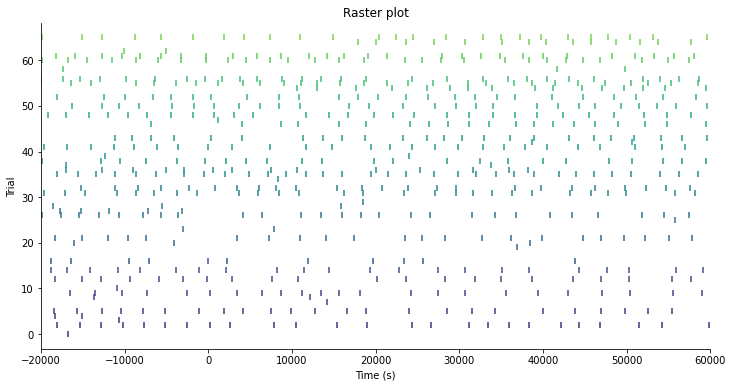

In [138]:
fig, ax = plt.subplots(figsize = (12,6))

cmap = plt.cm.viridis(np.linspace(0.1, .8, len(raster_array)))
for i, spike_times in enumerate(raster_array):
    # We plot only spikes that fall within the desired window
    ax.scatter(spike_times, i * np.ones_like(spike_times), marker='|', color = cmap[i])

ax.set_xlim(psth_beg*fs, psth_end*fs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Trial')
ax.set_title('Raster plot')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()